# Clustering Methods

## Introduction

We will be using the wine quality data set for demonstrating Clustering Methods. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data`.

We will be using the chemical properties (i.e. everything but quality and color) to cluster the wine. Though this is unsupervised learning, it can be fun to see how our clustering results map onto color and quality.

In [1]:
from __future__ import print_function
import os
data_path = ['data']

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline

In [3]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## Know Your Data

* Import the data and examine the features. 
* Note which are continuous, categorical, and boolean. 
* How many entries are there for the two colors and range of qualities? 
* Make a histogram plot of the quality for each of the wine colors.

In [4]:
# Import the data
filepath = os.sep.join(data_path + ['Wine_Quality_Data.csv'])

data = pd.read_csv(filepath)

data.head(4).T

,0,1,2,3
fixed_acidity,7.4,7.8,7.8,11.2
volatile_acidity,0.7,0.88,0.76,0.28
citric_acid,0,0,0.04,0.56
residual_sugar,1.9,2.6,2.3,1.9
chlorides,0.076,0.098,0.092,0.075
free_sulfur_dioxide,11,25,15,17
total_sulfur_dioxide,34,67,54,60
density,0.9978,0.9968,0.997,0.998
pH,3.51,3.2,3.26,3.16
sulphates,0.56,0.68,0.65,0.58


In [5]:
data.shape

(6497, 13)

The data types for each entry. The implementation of K-means in Scikit-learn is designed only to work with continuous data (even though it is sometimes used with categorical or boolean types). Fortunately, all the columns we will be using (everything except quality and color) are continuous.

In [6]:
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

The number of entries for each wine color.

In [7]:
data.color.value_counts()

white    4898
red      1599
Name: color, dtype: int64

The distribution of quality values.

In [8]:
data.quality.value_counts().sort_index()

3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

In [9]:
data["color"].value_counts()

white    4898
red      1599
Name: color, dtype: int64

Now for the histogram.

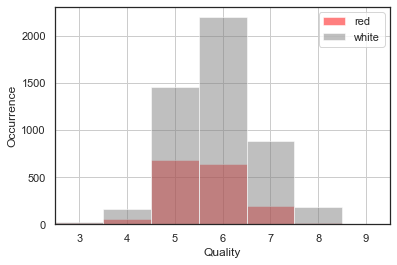

In [10]:
# seaborn styles
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

# custom colors
red = 'red' 
white = 'gray'

# set bins for histogram
bin_range = np.array([3, 4, 5, 6, 7, 8, 9])

# plot histogram of quality counts for red and white wines
ax = plt.axes()
for color, plot_color in zip(['red', 'white'], [red, white]):
    
    q_data = data.loc[data.color==color, 'quality']
    q_data.hist( bins=bin_range,
                alpha=0.5, ax=ax, 
                color=plot_color, label=color)

ax.legend()
ax.set(xlabel='Quality', ylabel='Occurrence')

# force tick labels to be in middle of region
ax.set_xlim(3,10)
ax.set_xticks(bin_range+0.5)
ax.set_xticklabels(bin_range);
ax.grid('off')


* Example the correlation and skew of the relevant variables--everything except color and quality.
* Perform any appropriate feature transformations and/or scaling.
* Examine the pairwise distribution of the variables with pairplots to verify scaling and normalization efforts.

In [11]:
float_columns = [x for x in data.columns if x not in ['color', 'quality']]

# The correlation matrix
corr_mat = data[float_columns].corr()

# Strip out the diagonal values for the next step
for x in range(len(float_columns)):
    corr_mat.iloc[x,x] = 0.0

corr_mat

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
fixed_acidity,0.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452
volatile_acidity,0.219008,0.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640
citric_acid,0.324436,-0.377981,0.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493
residual_sugar,-0.111981,-0.196011,0.142451,0.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415
chlorides,0.298195,0.377124,0.038998,-0.128940,0.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916
free_sulfur_dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,0.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838
total_sulfur_dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,0.000000,0.032395,-0.238413,-0.275727,-0.265740
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,0.000000,0.011686,0.259478,-0.686745
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,0.000000,0.192123,0.121248
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,0.000000,-0.003029


Show how much variables are correlated with Pairwise Maximal Correlation

In [12]:
# Pairwise maximal correlations
corr_mat.idxmax()

fixed_acidity                        density
volatile_acidity                   chlorides
citric_acid                    fixed_acidity
residual_sugar                       density
chlorides                          sulphates
free_sulfur_dioxide     total_sulfur_dioxide
total_sulfur_dioxide     free_sulfur_dioxide
density                       residual_sugar
pH                          volatile_acidity
sulphates                          chlorides
alcohol                                   pH
dtype: object

The above result can be graphically plotted

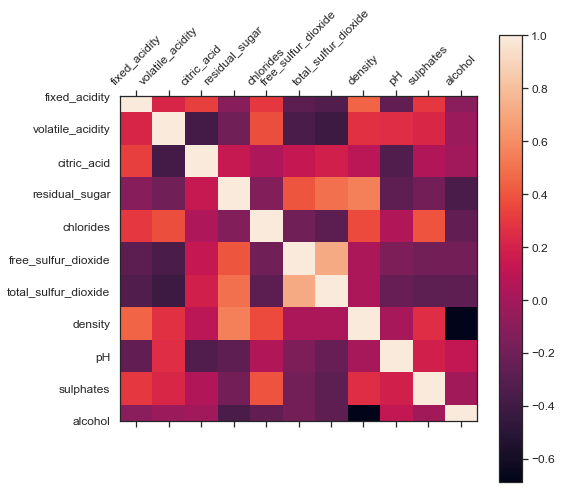

In [13]:
f = plt.figure(figsize=(8, 8))

#plt.matshow(data[float_columns].corr(), fignum=f.number)
plt.matshow(data[float_columns].corr(), fignum=f.number)

plt.xticks(range(len(float_columns)), float_columns, fontsize=12, rotation=45)
plt.yticks(range(len(float_columns)), float_columns, fontsize=12)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)

In [14]:
skew_columns = (data[float_columns]
                .skew()
                .sort_values(ascending=False))

sknew = (skew_columns > 0.75) | (skew_columns < 0.25)

skew_columns = skew_columns.loc[sknew]

skew_columns

chlorides               5.399828
sulphates               1.797270
fixed_acidity           1.723290
volatile_acidity        1.495097
residual_sugar          1.435404
free_sulfur_dioxide     1.220066
total_sulfur_dioxide   -0.001177
dtype: float64

## Data Preprocessing

**Scaling vs. Normalization: What’s the difference?**

One of the reasons that it’s easy to get confused between scaling and normalization is because the terms are sometimes used interchangeably and, to make it even more confusing, they are very similar! In both cases, you’re transforming the values of numeric variables so that the transformed data points have specific helpful properties.

The difference is that, in scaling, you’re changing the range of your data while in normalization you’re changing the shape of the distribution of your data. Let’s talk a little more in-depth about each of these options.

By scaling your variables, you can help compare different variables on equal footing.


### Data Transformation

**Feature Scaling with <code>sklearn.preprocessing.RobustScaler</code>**

This means that you’re transforming your data so that it fits within a specific scale, like 0–100 or 0–1. You want to scale data when you’re using methods based on measures of how far apart data points, like support vector machines, or SVM or k-nearest neighbors, or KNN. With these algorithms, a change of “1” in any numeric feature is given the same importance.

In [15]:
from sklearn.preprocessing import RobustScaler

sc = RobustScaler(quantile_range=(25.0, 75.0))

data[float_columns] = sc.fit_transform(data[float_columns])

data[float_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,6497.0,0.165621,0.997257,-2.461538,-0.461538,0.0,0.538462,6.846154
volatile_acidity,6497.0,0.292153,0.968450,-1.235294,-0.352941,0.0,0.647059,7.588235
citric_acid,6497.0,0.061666,1.037985,-2.214286,-0.428571,0.0,0.571429,9.642857
residual_sugar,6497.0,0.387815,0.755207,-0.380952,-0.190476,0.0,0.809524,9.968254
chlorides,6497.0,0.334587,1.297541,-1.407407,-0.333333,0.0,0.666667,20.888889
free_sulfur_dioxide,6497.0,0.063555,0.739558,-1.166667,-0.500000,0.0,0.500000,10.833333
total_sulfur_dioxide,6497.0,-0.028550,0.715467,-1.417722,-0.518987,0.0,0.481013,4.075949
density,6497.0,-0.041584,0.644876,-1.673118,-0.548387,0.0,0.451613,9.481720
pH,6497.0,0.040480,0.765653,-2.333333,-0.476190,0.0,0.523810,3.809524
sulphates,6497.0,0.125108,0.875329,-1.705882,-0.470588,0.0,0.529412,8.764706


**Observation**: 

- After applying the transformation with RobustScaler, the magnitude (standard deviation) of all features looks similar now.

- This can prepare for next step (K-Means clustering) because it is a distance-based algorithm, this difference of magnitude can create a problem.

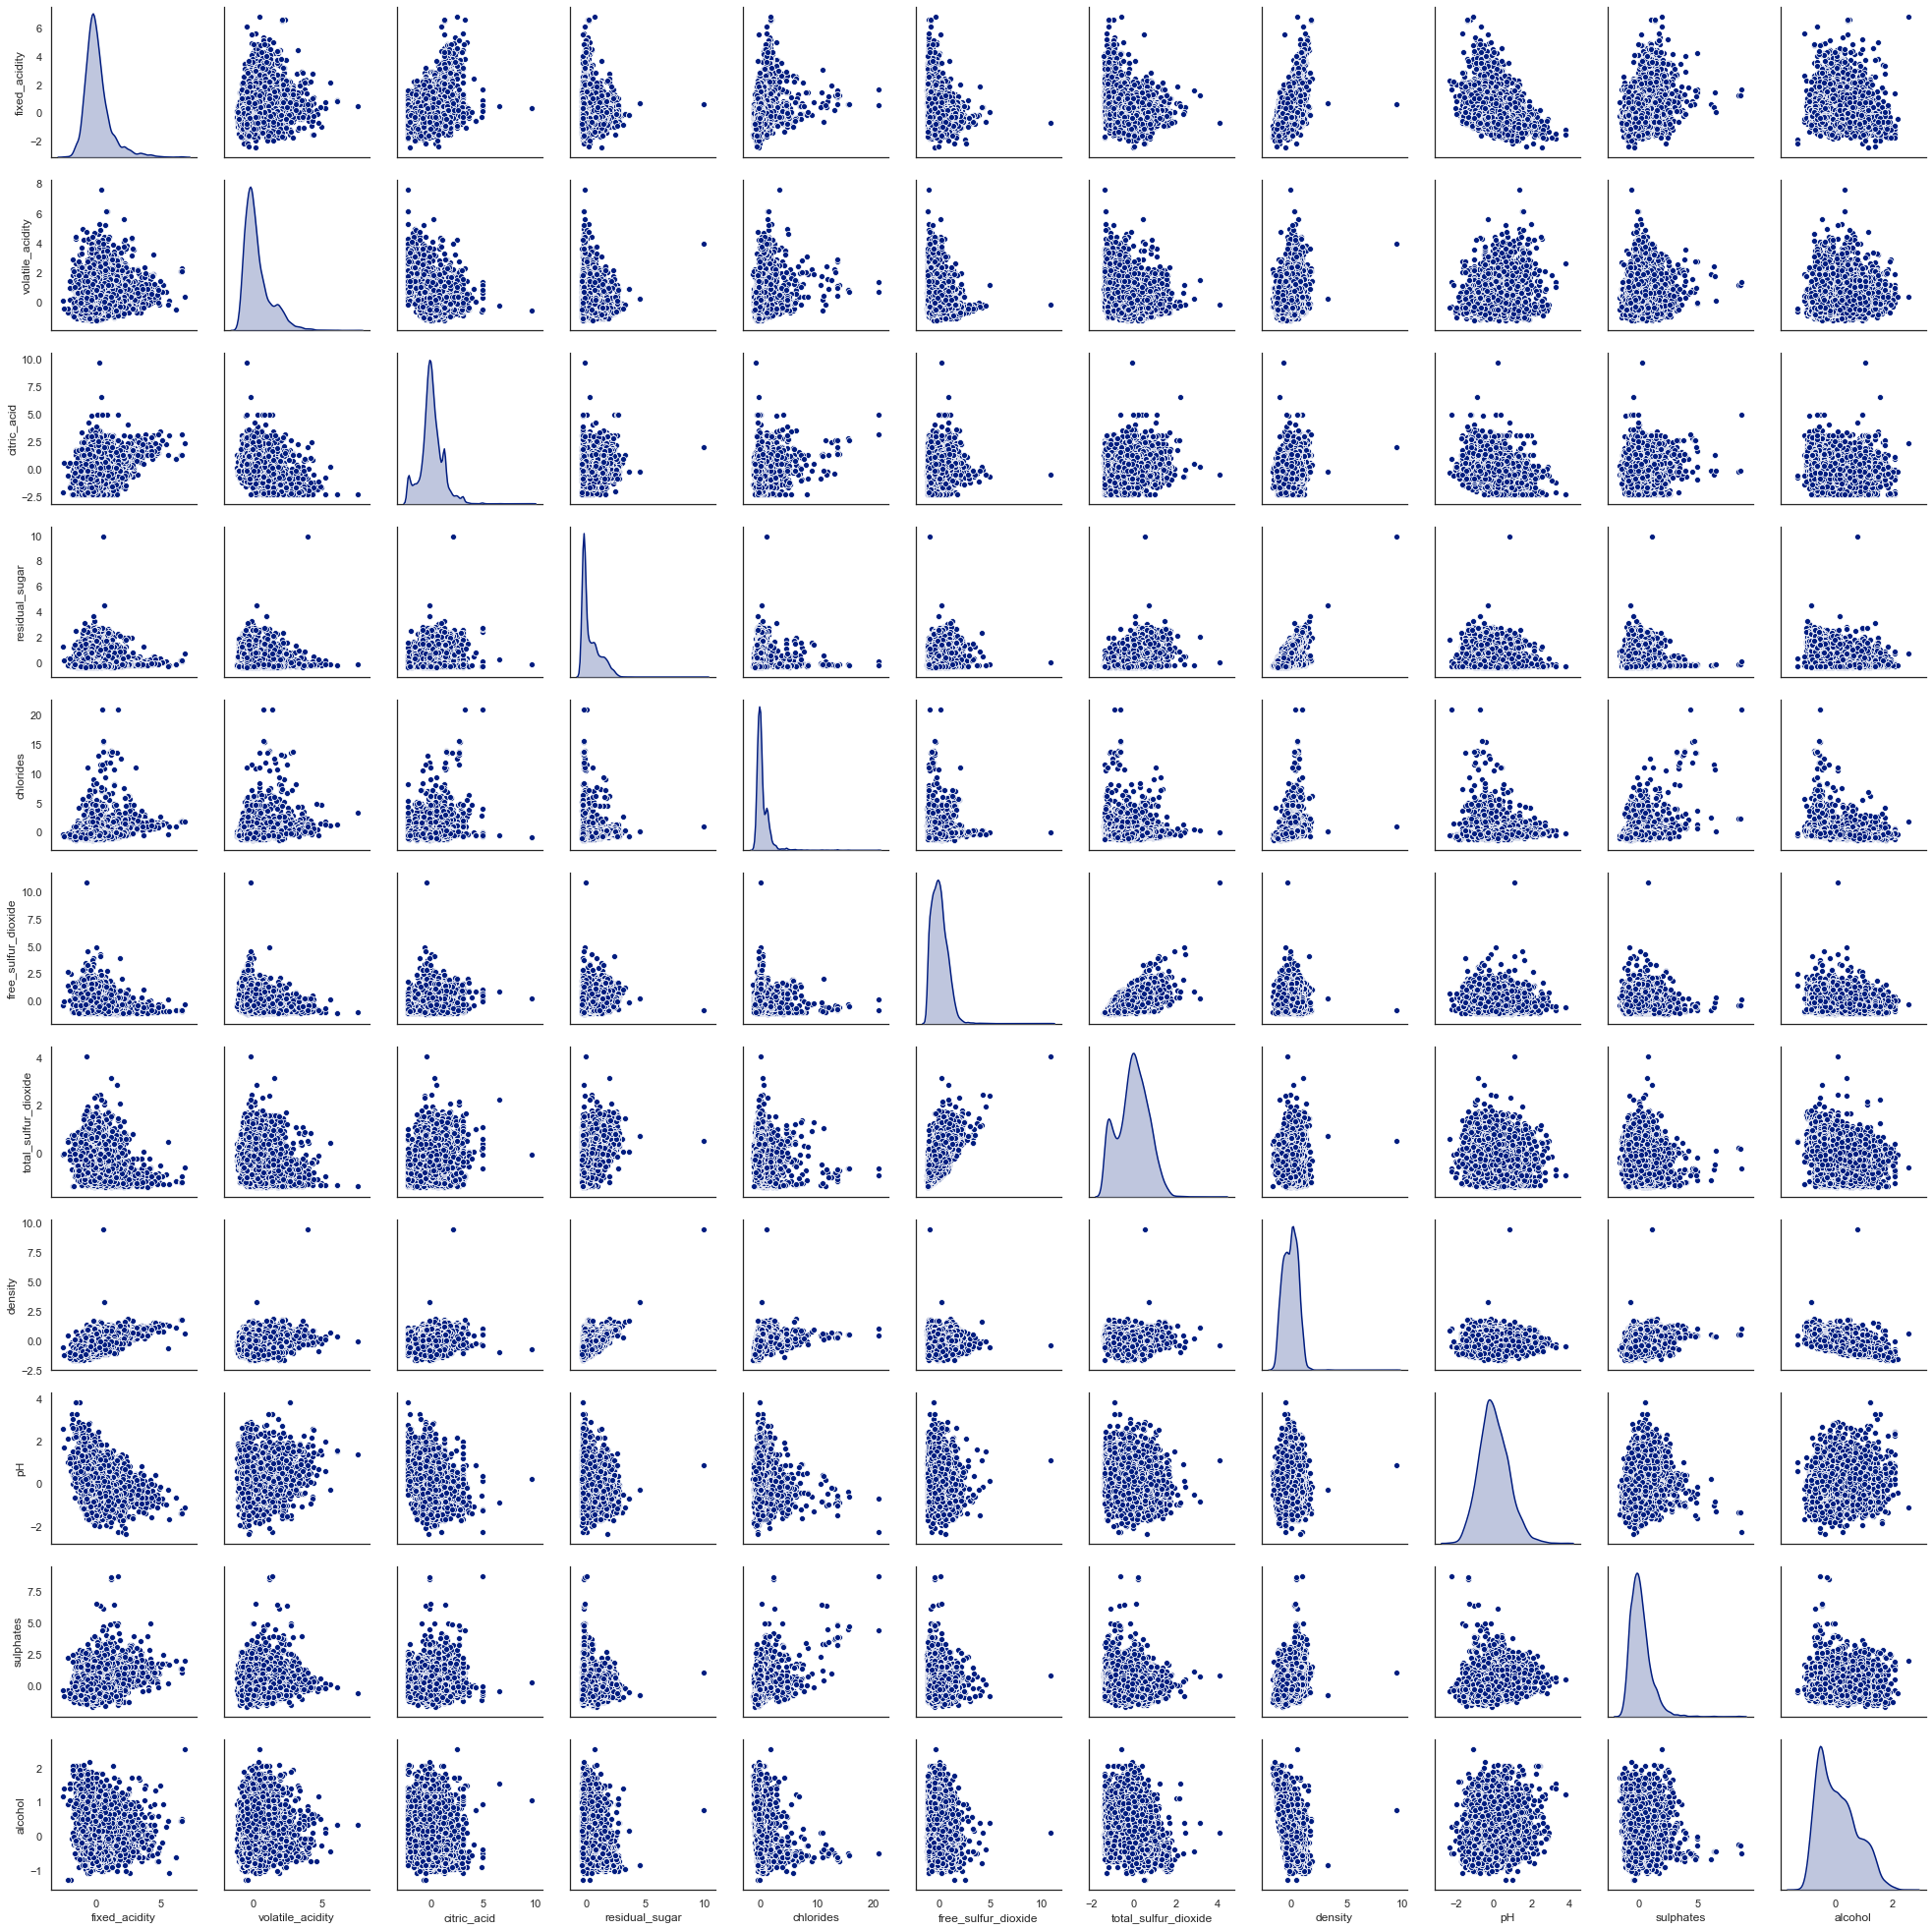

In [16]:
sns.set_context('notebook')

sns.pairplot(data[float_columns]
              , diag_kind="kde");

**Observation:** As a result, data range in the distribution of features is changed after the scaling

### Data Normalization

**Feature Transformation with stats.zcore**

Scaling just changes the range of your data. Normalization is a more radical transformation. The point of normalization is to change your observations so that they can be described as a normal distribution.

In general, you’ll only want to normalize your data if you’re going to be using a machine learning or statistics technique that assumes your data is normally distributed. Some examples of these include t-tests, ANOVAs, linear regression

**zscore** should be used this case instead of boxcox because some negative datapoints lie in dataset

In [17]:
from scipy.stats import zscore

for col in float_columns:
    data[col] = zscore(data[col])

Finally, the pairplot of the transformed and scaled features.

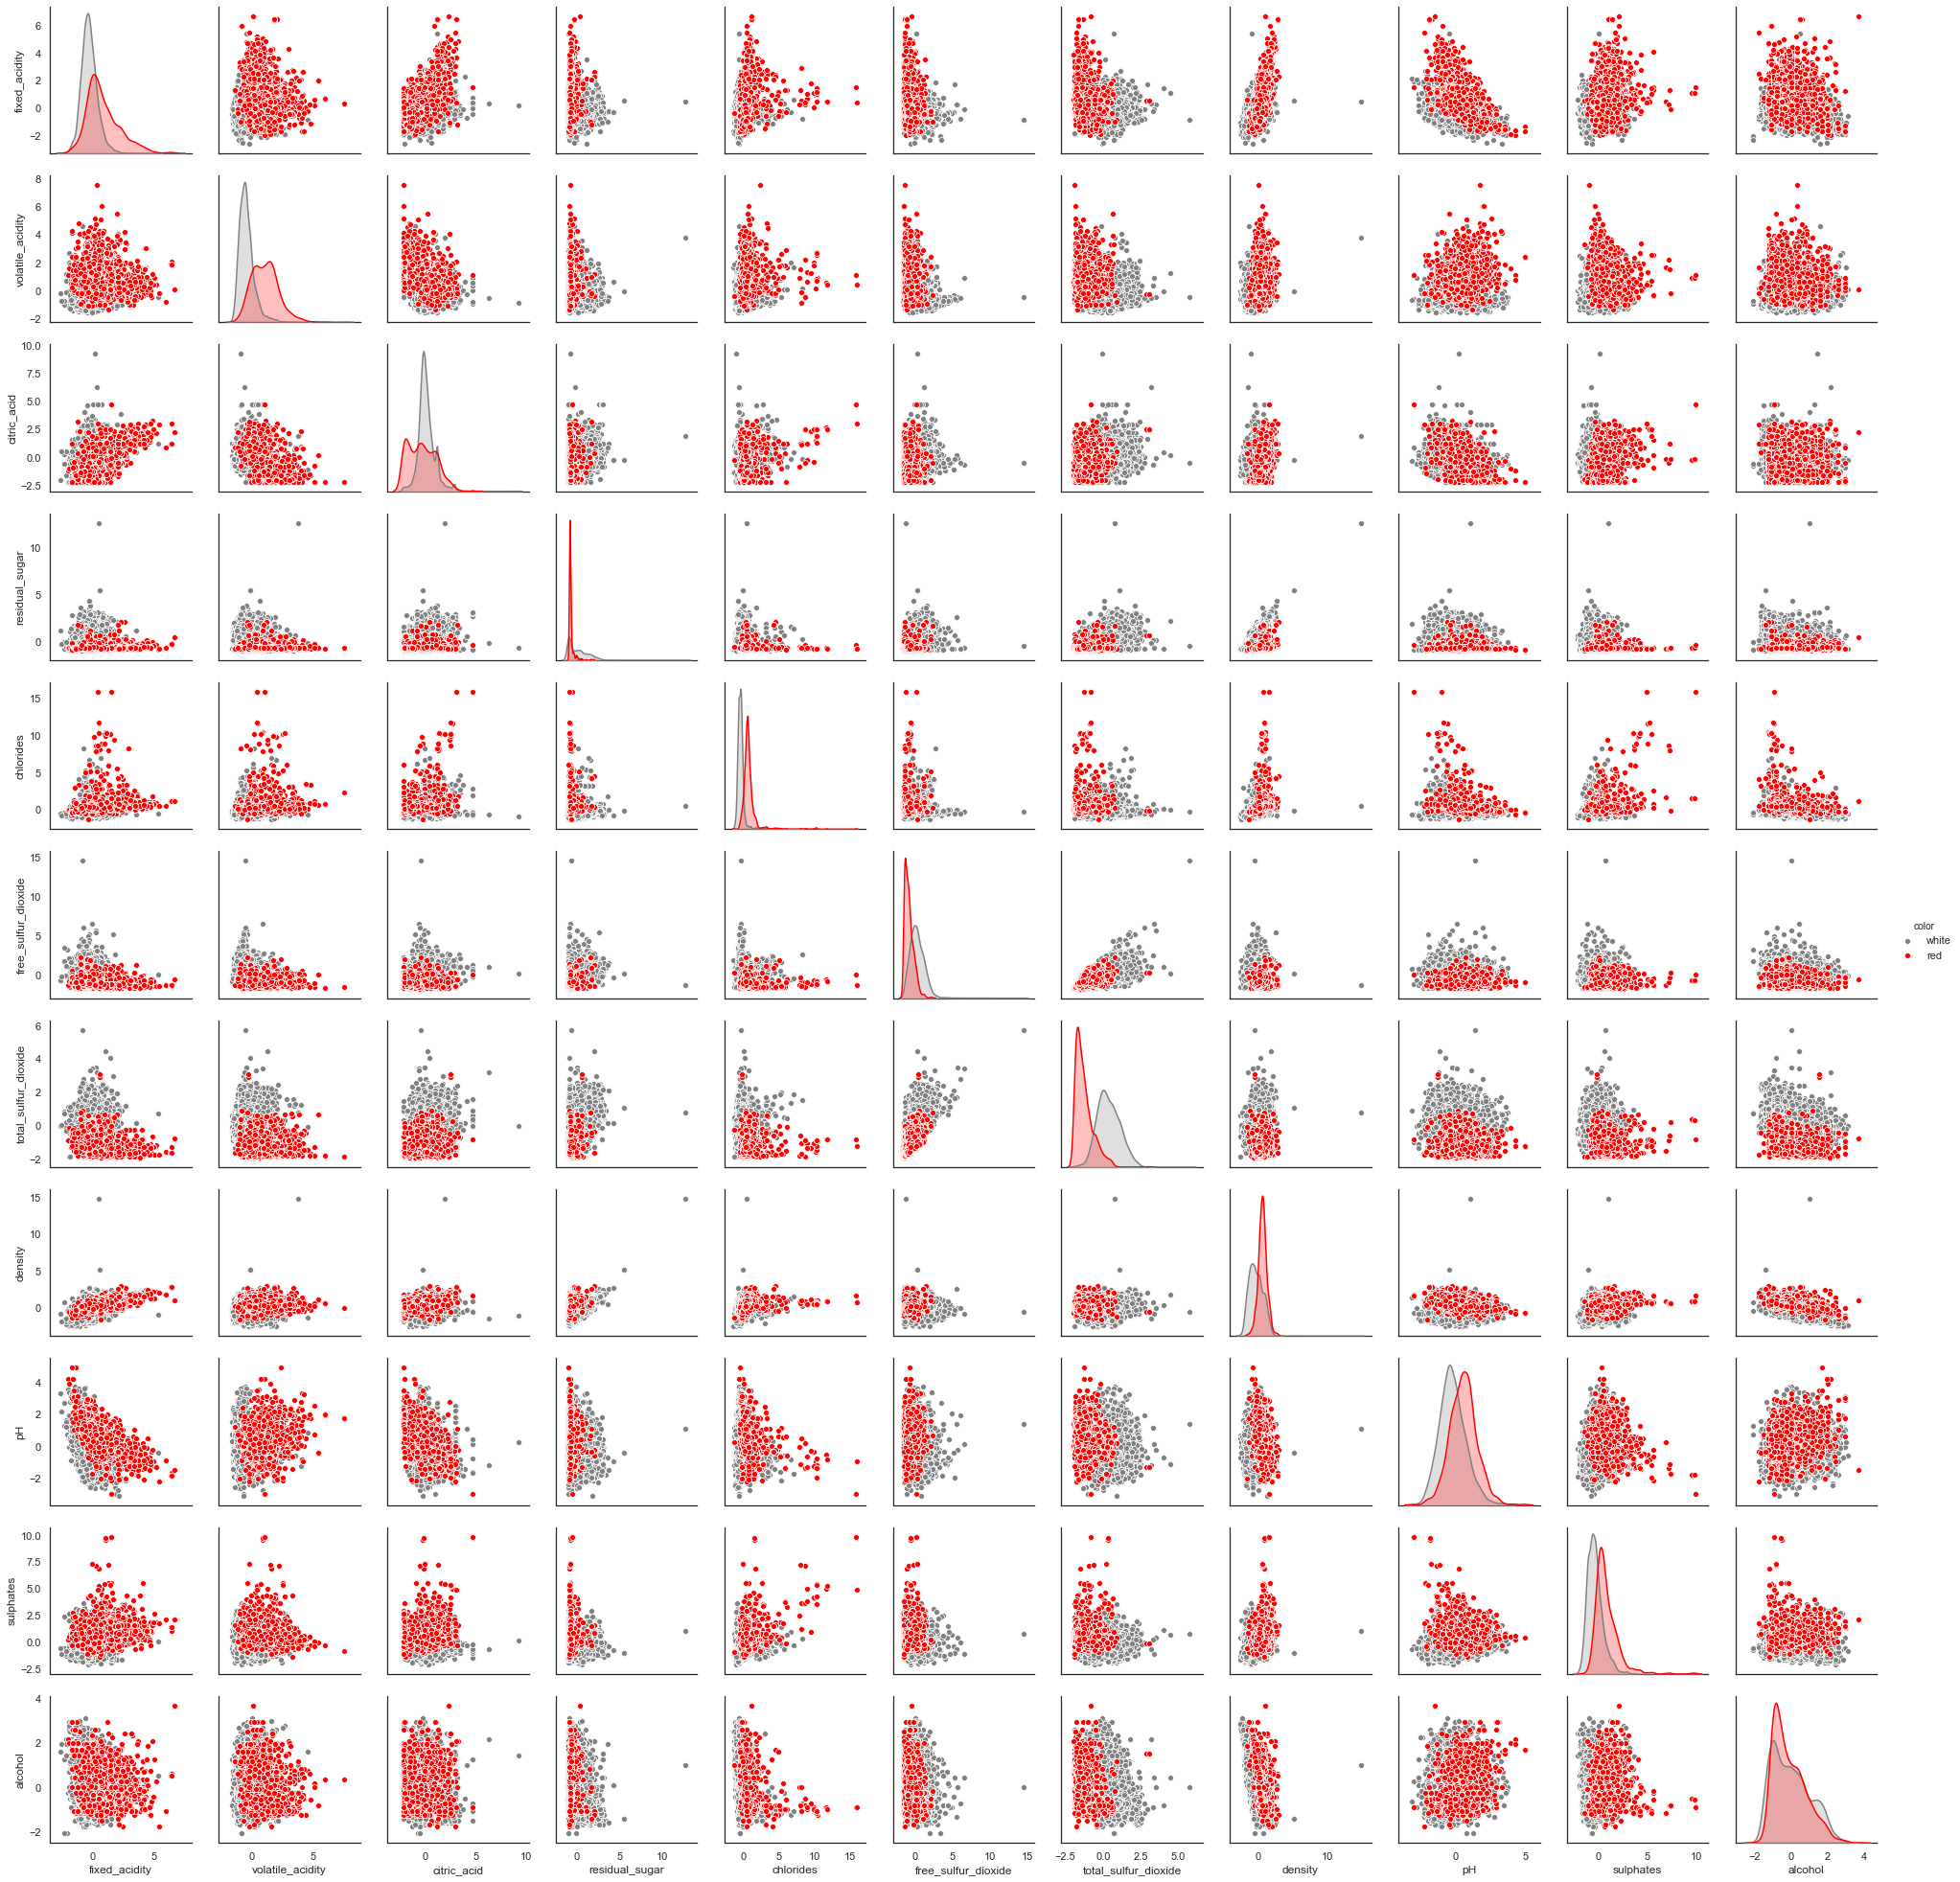

In [18]:
sns.set_context('notebook')

sns.pairplot(data[float_columns + ['color']]
             , hue='color'
             , hue_order=['white', 'red']
             , palette={'red':red, 'white':white});

In [19]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,5,red
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,5,red
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,5,red
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,6,red
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,5,red


Save prepared data as pickle for next step

In [20]:
import pickle

pkl_path = os.sep.join(data_path + ['win_quality_preprocessing.pkl'])

output = open(pkl_path , 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(data, output)

output.close()